# 1. EXPLORATORY ON A TICKER

## 1.1 DATA IMPORT AND PREPROCESSING

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('MSN.csv') #Give path to desire CSV

# Convert Date/Time to datetime
data['Date/Time'] = pd.to_datetime(data['Date/Time'])

# Sort by Date/Time
data = data.sort_values('Date/Time')

# Set Date/Time as the index for easier plotting
data.set_index('Date/Time', inplace=True)

In [2]:
data = data.drop(columns = 'Ticker')

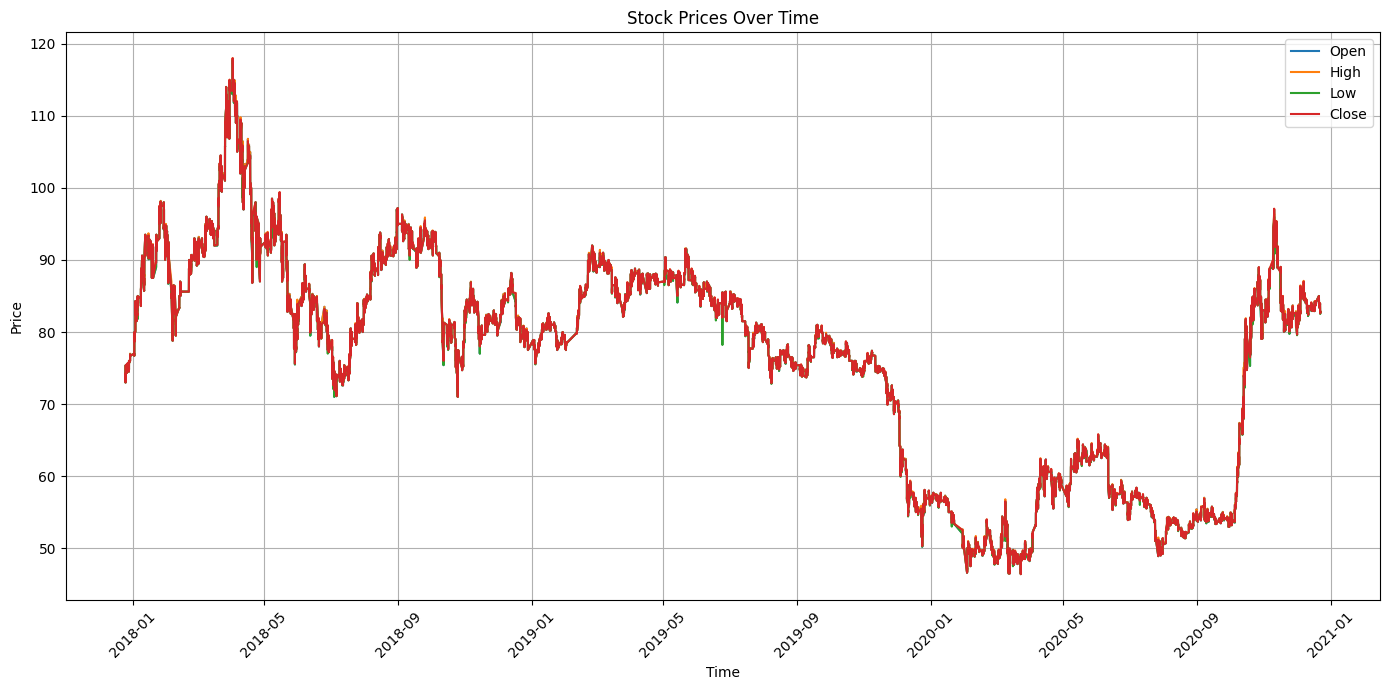

In [3]:
# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Open'], label='Open')
plt.plot(data.index, data['High'], label='High')
plt.plot(data.index, data['Low'], label='Low')
plt.plot(data.index, data['Close'], label='Close')

# Customize the plot
plt.title('Stock Prices Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

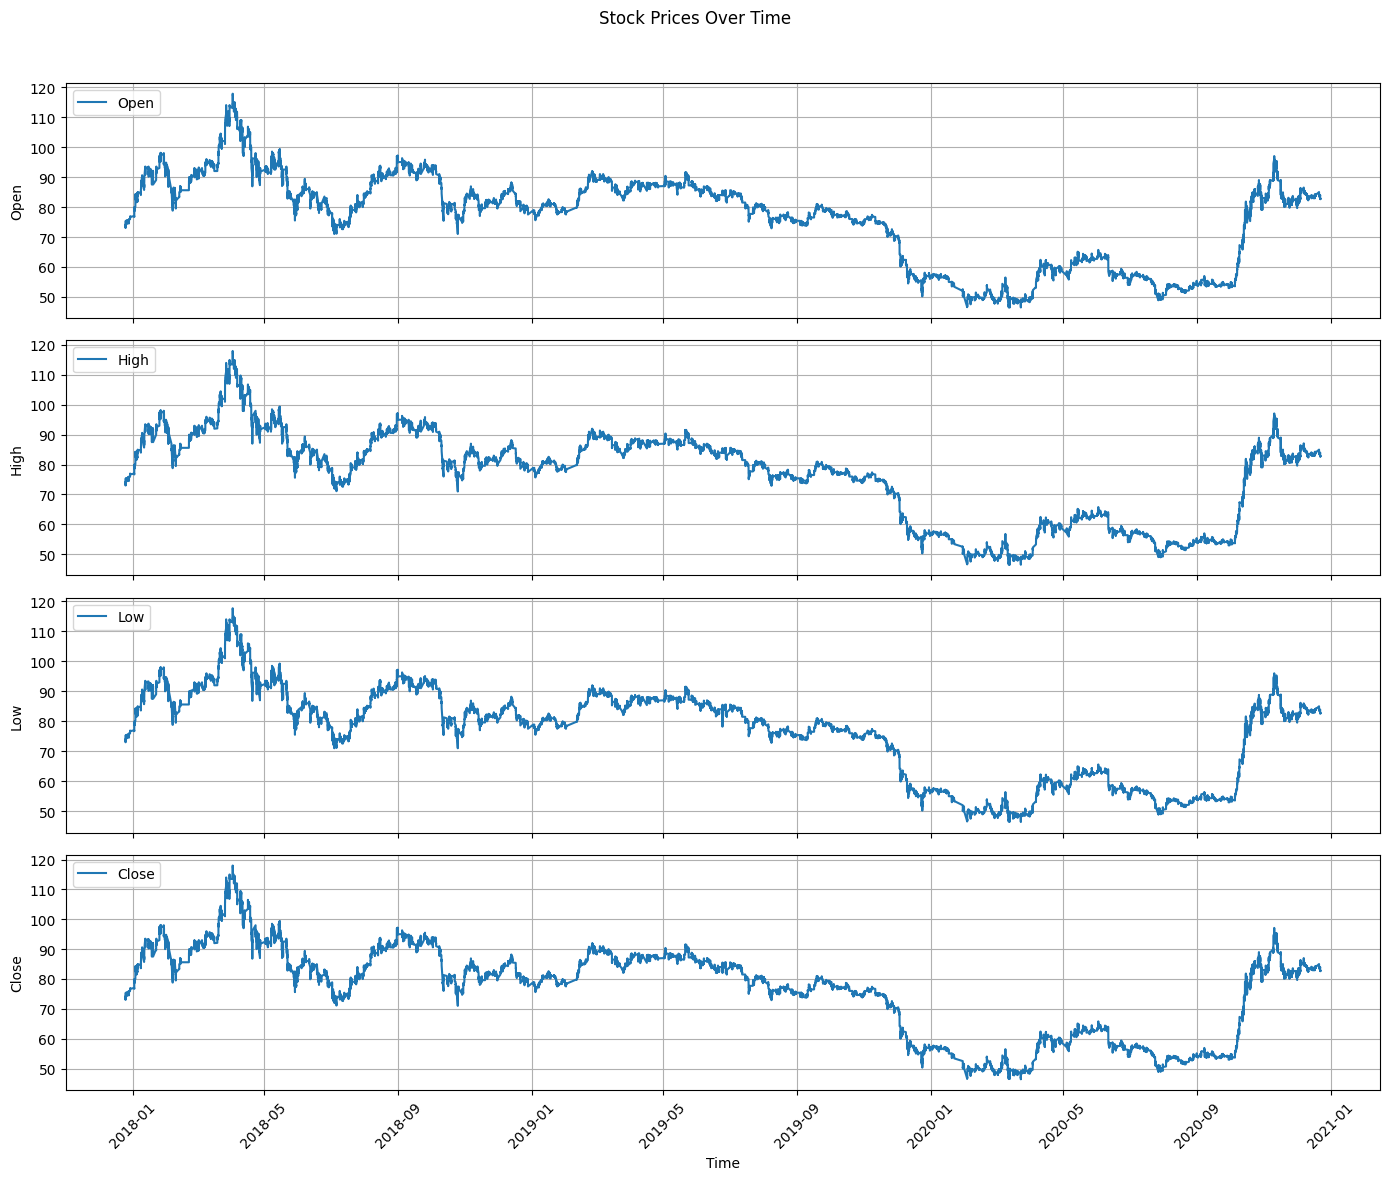

In [4]:
# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Plot each column
columns_to_plot = ['Open', 'High', 'Low', 'Close']
for i, column in enumerate(columns_to_plot):
    axs[i].plot(data.index, data[column], label=column, color='tab:blue')
    axs[i].set_ylabel(column)
    axs[i].legend(loc='upper left')
    axs[i].grid(True)

# Set common labels
fig.suptitle('Stock Prices Over Time')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show plot
plt.show()

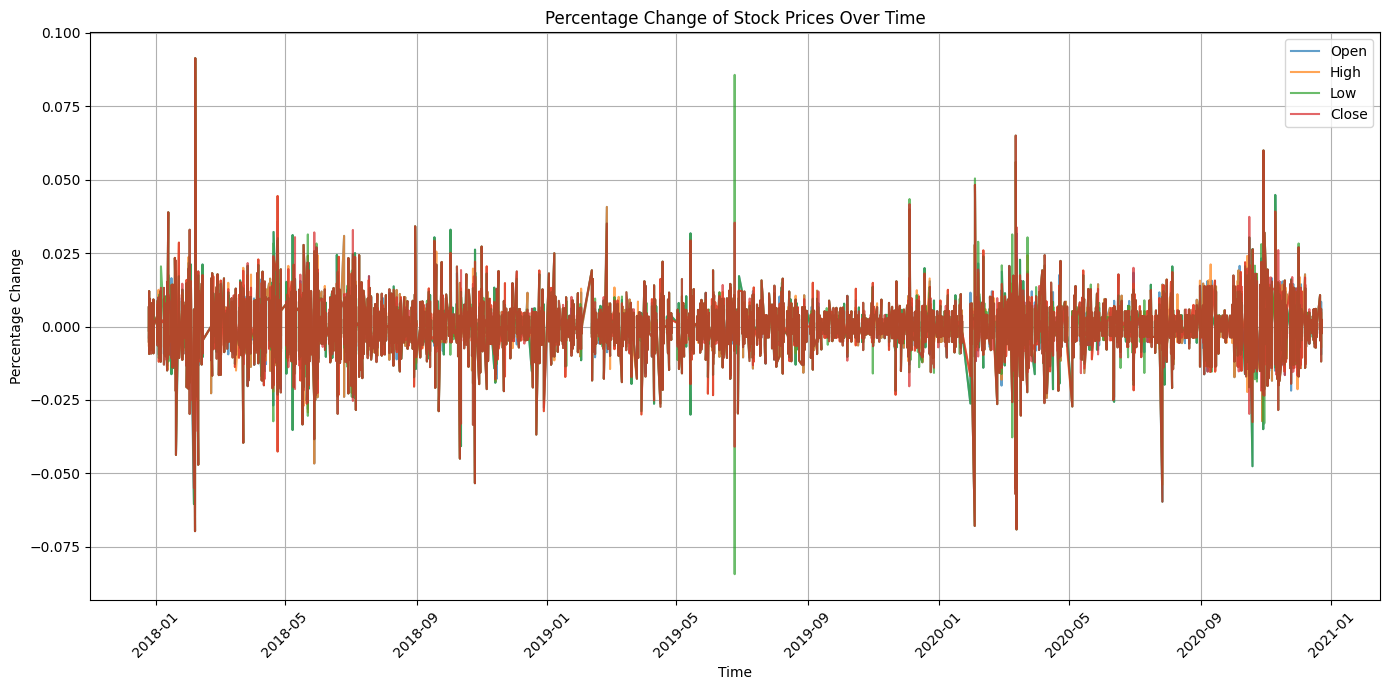

In [5]:
# Calculate percentage change
data_pct_change = data.pct_change()

# Plot percentage change
plt.figure(figsize=(14, 7))
plt.plot(data_pct_change.index, data_pct_change['Open'], label='Open', alpha=0.7)
plt.plot(data_pct_change.index, data_pct_change['High'], label='High', alpha=0.7)
plt.plot(data_pct_change.index, data_pct_change['Low'], label='Low', alpha=0.7)
plt.plot(data_pct_change.index, data_pct_change['Close'], label='Close', alpha=0.7)

# Customize the plot
plt.title('Percentage Change of Stock Prices Over Time')
plt.xlabel('Time')
plt.ylabel('Percentage Change')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()


## 1.2 LSTM TO PREDICT CLOSE PRICE

In [6]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

import numpy as np

In [7]:
# Using Close prices for prediction
dataset = data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [8]:
# Create the training and testing datasets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [9]:
# Function to create dataset
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [10]:
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [11]:
# Build and train the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=1)

108272/108272 [==============================] - 716s 7ms/step - loss: 6.0583e-04


In [13]:
# Predicting the stock prices
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transforming back to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

846/846 [==============================] - 3s 3ms/step


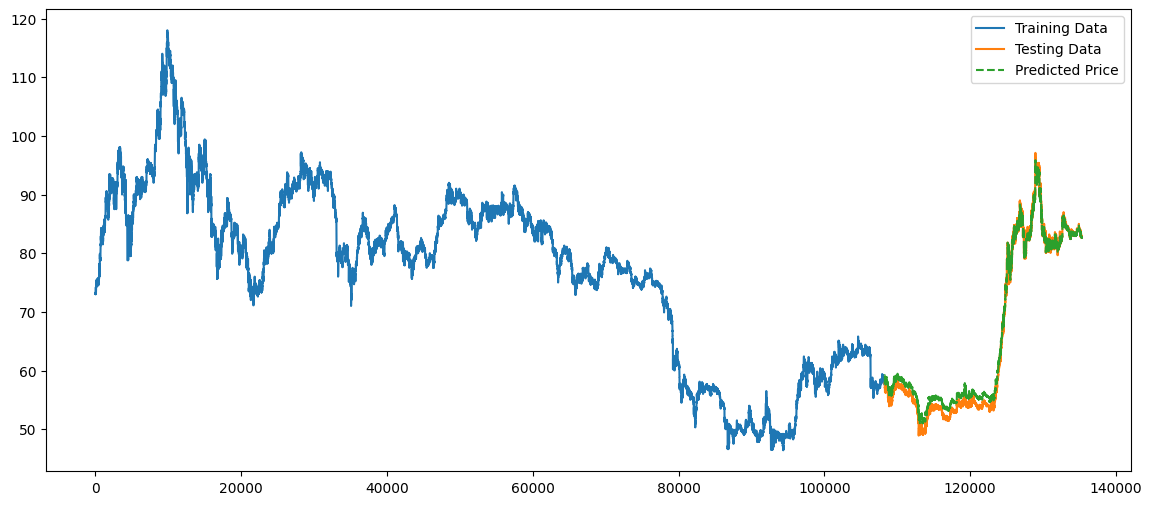

In [14]:
# Prepare the actual prices for plotting
train_actual = scaler.inverse_transform(train_data[time_step+1:])
test_actual = scaler.inverse_transform(test_data[time_step+1:])

# Plotting the results
plt.figure(figsize=(14, 6))
plt.plot(range(time_step+1, len(train_actual) + time_step+1), train_actual, label='Training Data')
plt.plot(range(len(train_actual) + time_step+1, len(train_actual) + len(test_actual) + time_step+1), test_actual, label='Testing Data')
plt.plot(range(len(train_actual) + time_step+1, len(train_actual) + len(test_actual) + time_step+1), test_predict, label='Predicted Price', linestyle='--')
plt.legend()
plt.show()

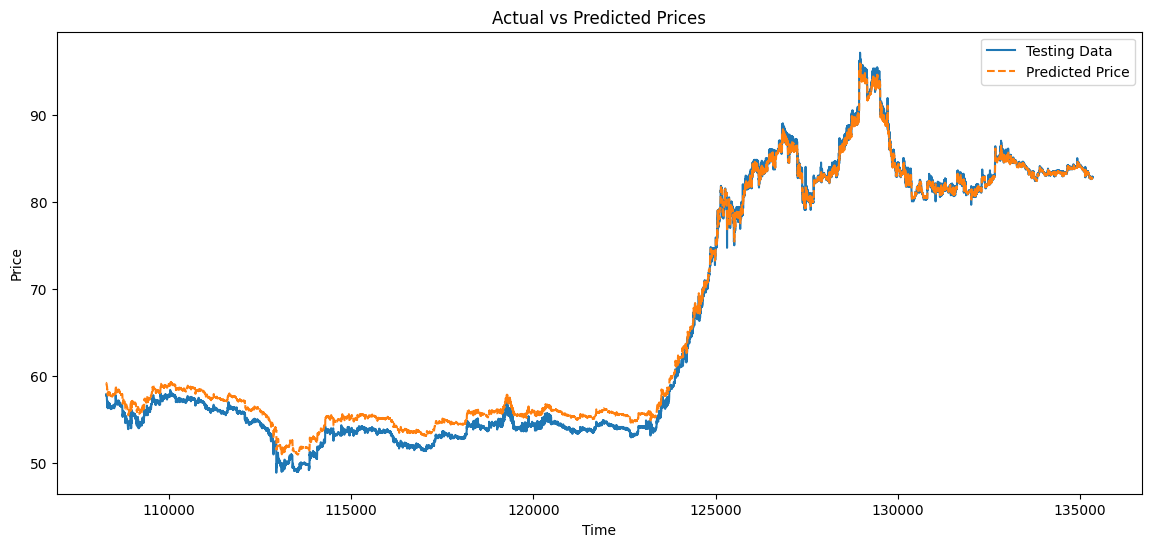

In [15]:
# Plotting the results for the test data only
plt.figure(figsize=(14, 6))
plt.plot(range(len(train_actual) + time_step + 1, len(train_actual) + len(test_actual) + time_step + 1), test_actual, label='Testing Data')
plt.plot(range(len(train_actual) + time_step + 1, len(train_actual) + len(test_actual) + time_step + 1), test_predict, label='Predicted Price', linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

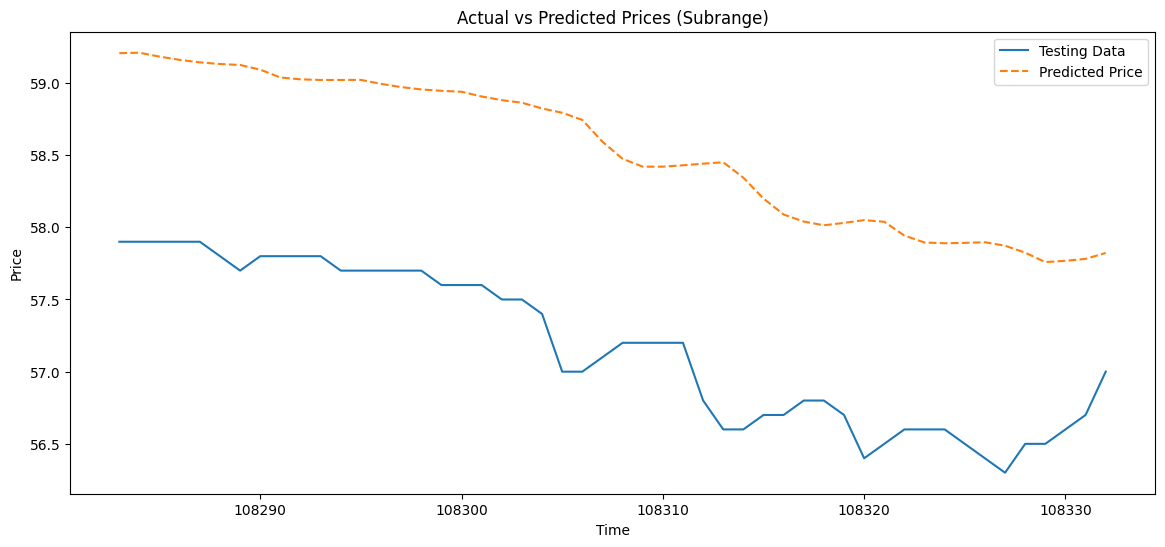

In [16]:
# Visualization for a particular range of result
start_index = 0
end_index = 50

plt.figure(figsize=(14, 6))
plt.plot(range(len(train_actual) + time_step + 1 + start_index, len(train_actual) + time_step + 1 + end_index), 
         test_actual[start_index:end_index], label='Testing Data')
plt.plot(range(len(train_actual) + time_step + 1 + start_index, len(train_actual) + time_step + 1 + end_index), 
         test_predict[start_index:end_index], label='Predicted Price', linestyle='--')
plt.title('Actual vs Predicted Prices (Subrange)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [17]:
model.save('MSN.h5')

## 1.3 PREDICT ON DATA OF DATE INSTEAD OF MINUTE

In [136]:
# Resample the data to daily frequency and aggregate
daily_df = data.resample('D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
})

# Display the daily aggregated data
print("Dataframe before drop null")
print(daily_df.isnull().sum())
daily_df = daily_df.dropna(axis=0, how='all')

print("Dataframe after drop null")
print(daily_df.isnull().sum())

print(daily_df.head())

Dataframe before drop null
Open     346
High     346
Low      346
Close    346
dtype: int64
Dataframe after drop null
Open     0
High     0
Low      0
Close    0
dtype: int64
            Open  High   Low  Close
Date/Time                          
2017-12-25  73.1  75.4  73.0   74.2
2017-12-26  74.9  75.5  74.3   75.5
2017-12-27  74.9  75.7  74.8   75.0
2017-12-28  75.0  76.0  74.5   75.7
2017-12-29  76.0  77.0  76.0   76.7


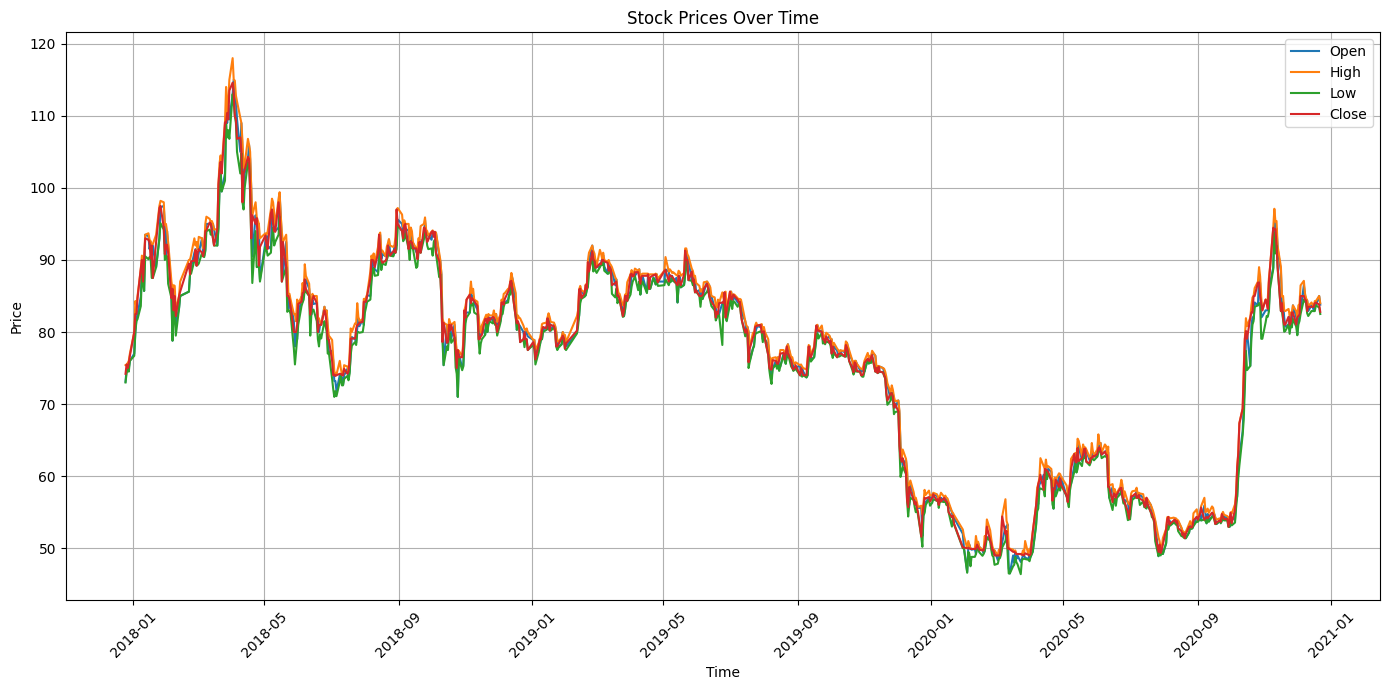

In [137]:
# Plot the daily_df
plt.figure(figsize=(14, 7))
plt.plot(daily_df.index, daily_df['Open'], label='Open')
plt.plot(daily_df.index, daily_df['High'], label='High')
plt.plot(daily_df.index, daily_df['Low'], label='Low')
plt.plot(daily_df.index, daily_df['Close'], label='Close')

# Customize the plot
plt.title('Stock Prices Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [144]:
# Using Close prices for prediction
dataset = daily_df['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create the training and testing datasets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [145]:
# Build and train the LSTM model
day_model = Sequential()
day_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
day_model.add(LSTM(50, return_sequences=False))
day_model.add(Dense(25))
day_model.add(Dense(1))

In [146]:
day_model.compile(optimizer='adam', loss='mean_squared_error')
day_model.fit(X_train, y_train, batch_size=1, epochs=1)

587/587 [==============================] - 6s 7ms/step - loss: 0.0059


In [147]:
# Predicting the stock prices
train_predict = day_model.predict(X_train)
test_predict = day_model.predict(X_test)

# Transforming back to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

5/5 [==============================] - 0s 4ms/step


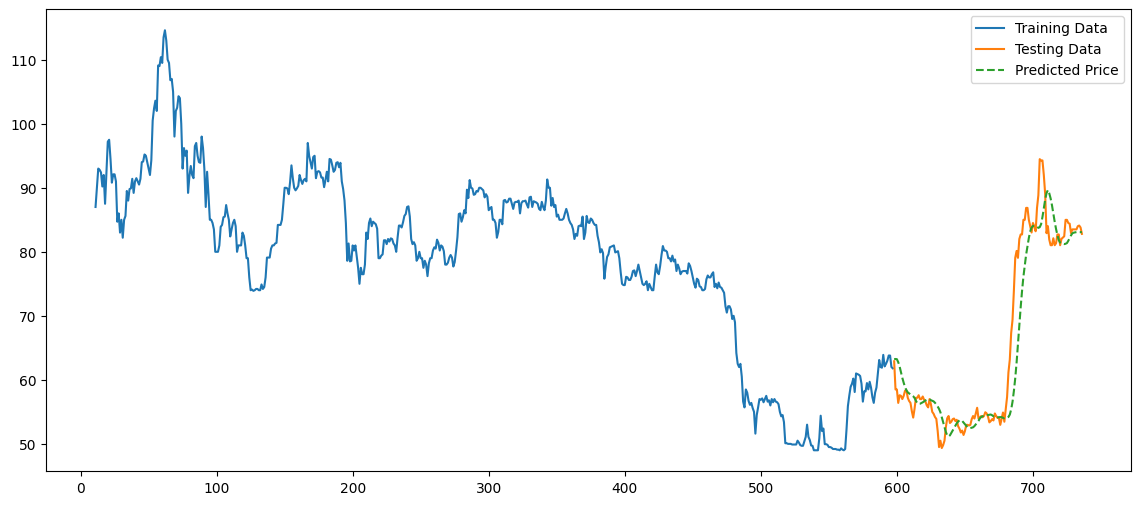

In [148]:
# Prepare the actual prices for plotting
train_actual = scaler.inverse_transform(train_data[time_step+1:])
test_actual = scaler.inverse_transform(test_data[time_step+1:])

# Plotting the results
plt.figure(figsize=(14, 6))
plt.plot(range(time_step+1, len(train_actual) + time_step+1), train_actual, label='Training Data')
plt.plot(range(len(train_actual) + time_step+1, len(train_actual) + len(test_actual) + time_step+1), test_actual, label='Testing Data')
plt.plot(range(len(train_actual) + time_step+1, len(train_actual) + len(test_actual) + time_step+1), test_predict, label='Predicted Price', linestyle='--')
plt.legend()
plt.show()

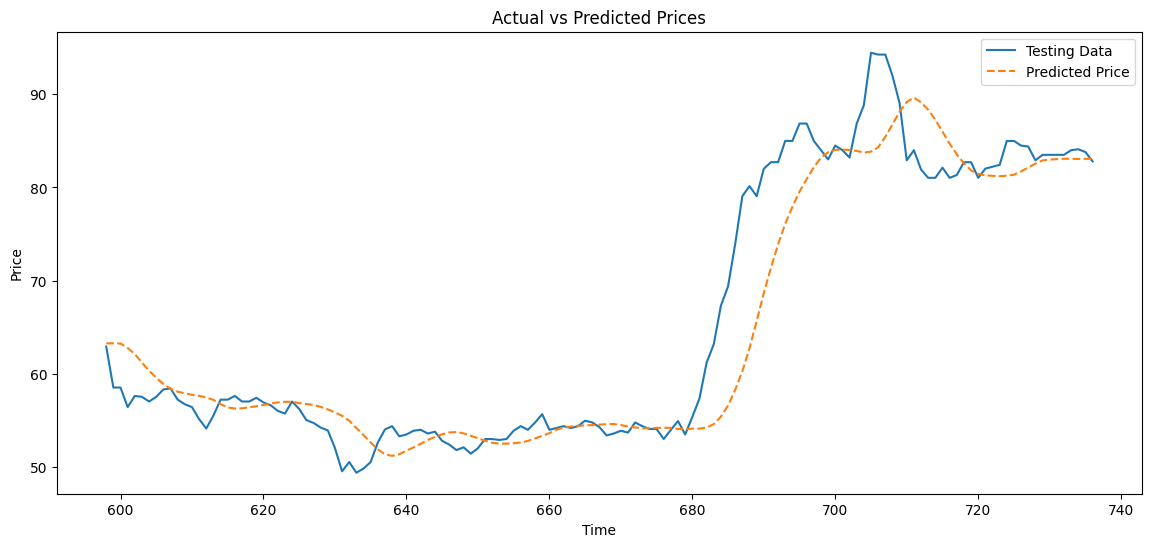

In [149]:
# Plotting the results for the test data only
plt.figure(figsize=(14, 6))
plt.plot(range(len(train_actual) + time_step + 1, len(train_actual) + len(test_actual) + time_step + 1), test_actual, label='Testing Data')
plt.plot(range(len(train_actual) + time_step + 1, len(train_actual) + len(test_actual) + time_step + 1), test_predict, label='Predicted Price', linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# 2. PIPELINE FOR EACH TICKER

In [49]:
# Define pipeline for each ticker
def pipeline(filepath, finetune = False):
# Finetune = Yes if you want to train the model again on dataset of filepath (~ 5 minutes)
    # Load data
    data = pd.read_csv(filepath)
    
    # Convert Date/Time to datetime
    data['Date/Time'] = pd.to_datetime(data['Date/Time'])
    
    # Sort by Date/Time
    data = data.sort_values('Date/Time')
    
    # Set Date/Time as the index for easier plotting
    data.set_index('Date/Time', inplace=True)

    data = data.drop(columns = 'Ticker')

    # Plot the data
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['Open'], label='Open')
    plt.plot(data.index, data['High'], label='High')
    plt.plot(data.index, data['Low'], label='Low')
    plt.plot(data.index, data['Close'], label='Close')
    
    # Customize the plot
    plt.title('Stock Prices Over Time')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

    # Using Close prices for prediction
    dataset = data['Close'].values.reshape(-1, 1)
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    # Create the training and testing datasets
    train_size = int(len(scaled_data) * 0.8)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size:]

    time_step = 10
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)
    
    # Reshape input to be [samples, time steps, features]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    if finetune:
        model.fit(X_train, y_train, batch_size=1, epochs=1)
    
    # Predicting the stock prices
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    # Transforming back to original scale
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    # Prepare the actual prices for plotting
    train_actual = scaler.inverse_transform(train_data[time_step+1:])
    test_actual = scaler.inverse_transform(test_data[time_step+1:])
    
    # Plotting the results
    plt.figure(figsize=(14, 6))
    plt.plot(range(time_step+1, len(train_actual) + time_step+1), train_actual, label='Training Data')
    plt.plot(range(len(train_actual) + time_step+1, len(train_actual) + len(test_actual) + time_step+1), test_actual, label='Testing Data')
    plt.plot(range(len(train_actual) + time_step+1, len(train_actual) + len(test_actual) + time_step+1), test_predict, label='Predicted Price', linestyle='--')
    plt.legend()
    plt.show()

    # Plotting the results for the test data only
    plt.figure(figsize=(14, 6))
    plt.plot(range(len(train_actual) + time_step + 1, len(train_actual) + len(test_actual) + time_step + 1), test_actual, label='Testing Data', color = 'orange')
    plt.plot(range(len(train_actual) + time_step + 1, len(train_actual) + len(test_actual) + time_step + 1), test_predict, label='Predicted Price', linestyle='--', color = 'green')
    plt.title('Actual vs Predicted Prices')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

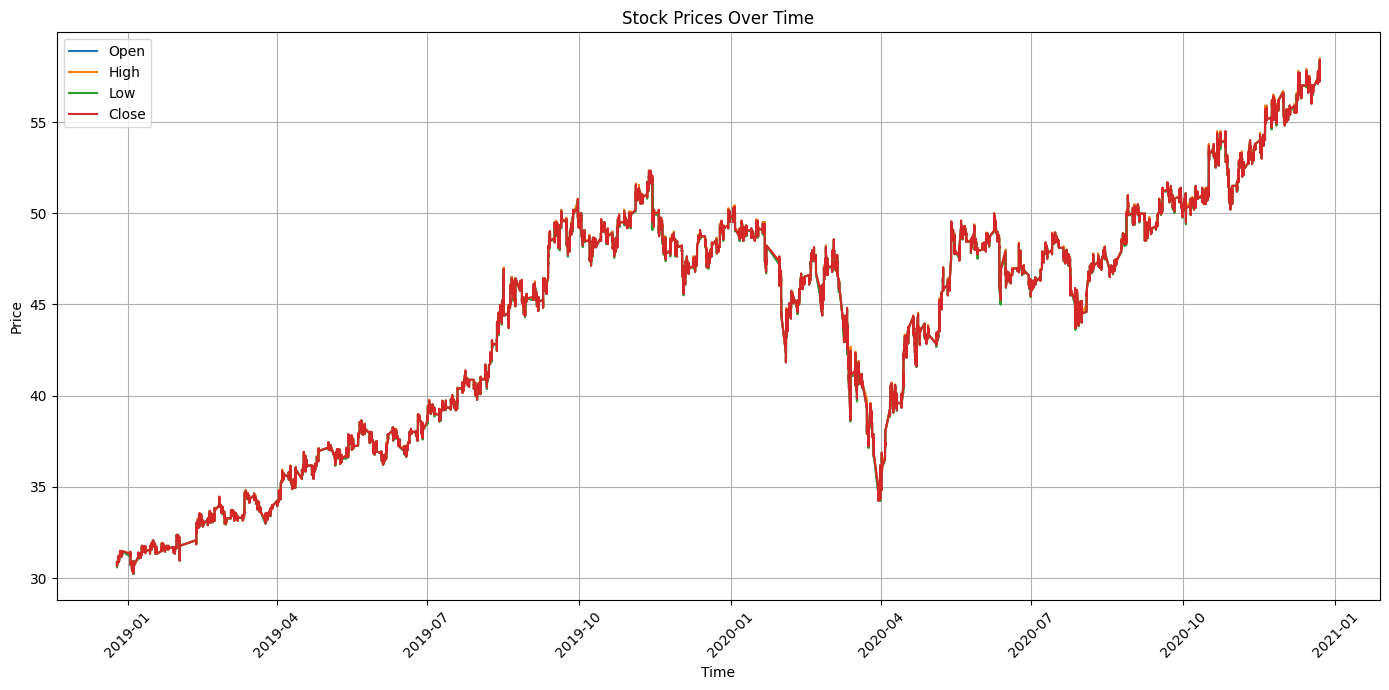

609/609 [==============================] - 3s 4ms/step


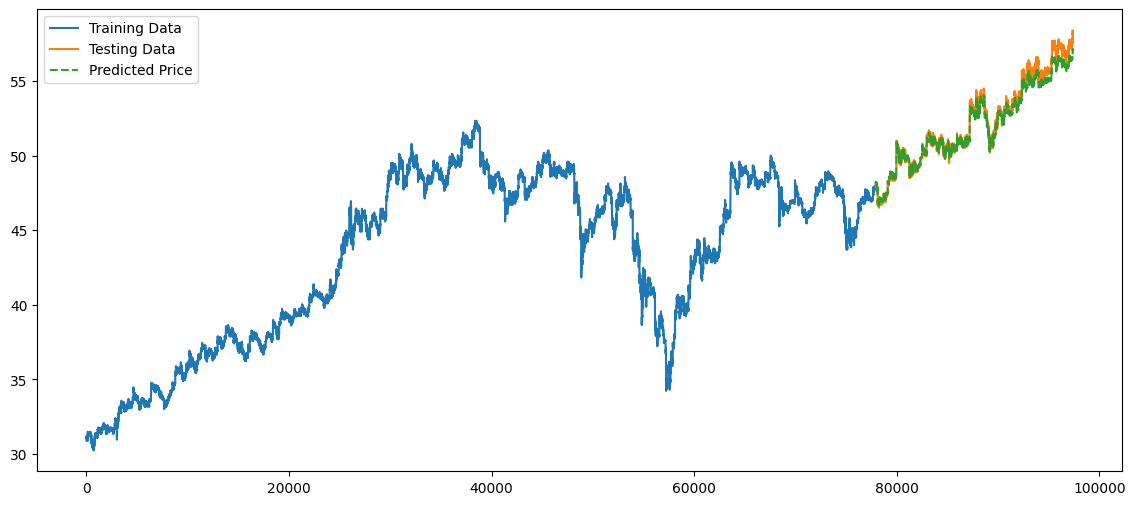

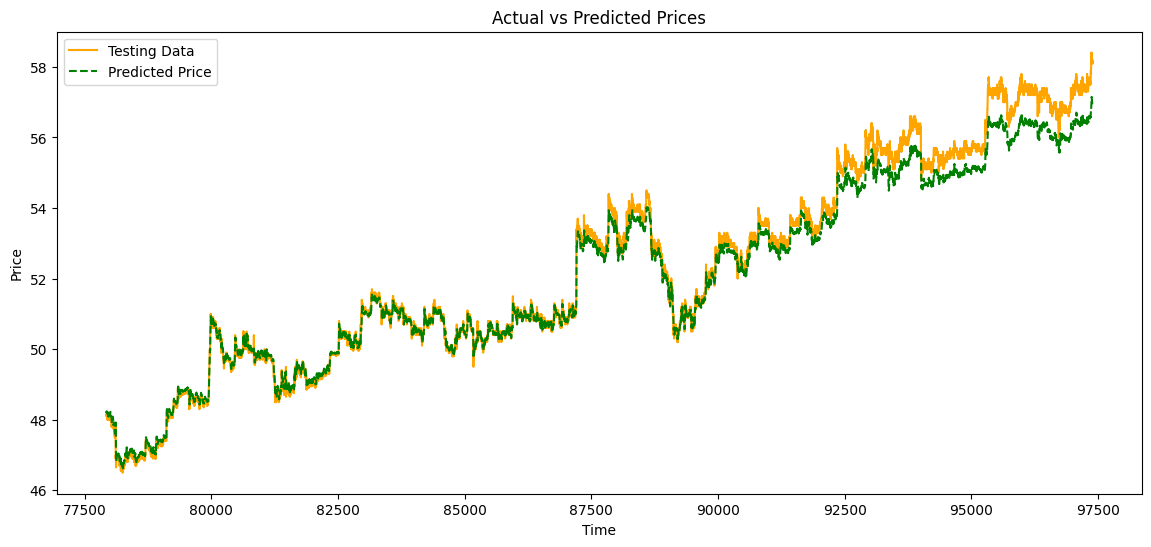

In [261]:
pipeline("FPT.csv", False)

# 3. MONTE-CARLO SIMULATION FOR MULTIPLE FUTUREPATH ESTIMATION

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
# Load data
data = pd.read_csv('MSN.csv')

# Convert Date/Time to datetime
data['Date/Time'] = pd.to_datetime(data['Date/Time'])

# Sort by Date/Time
data = data.sort_values('Date/Time')

# Set Date/Time as the index for easier plotting
data.set_index('Date/Time', inplace=True)

# Calculate daily returns
data['Daily Return'] = data['Close'].pct_change()

In [34]:
# Define parameters
num_simulations = 1000  # Number of simulations
num_minutes = 250  # Number of days to simulate (e.g., 1 year of trading days)

# Get the last closing price
last_price = data['Close'].iloc[-num_minutes]

# Create an empty array to hold the simulation results
simulation_df = pd.DataFrame()

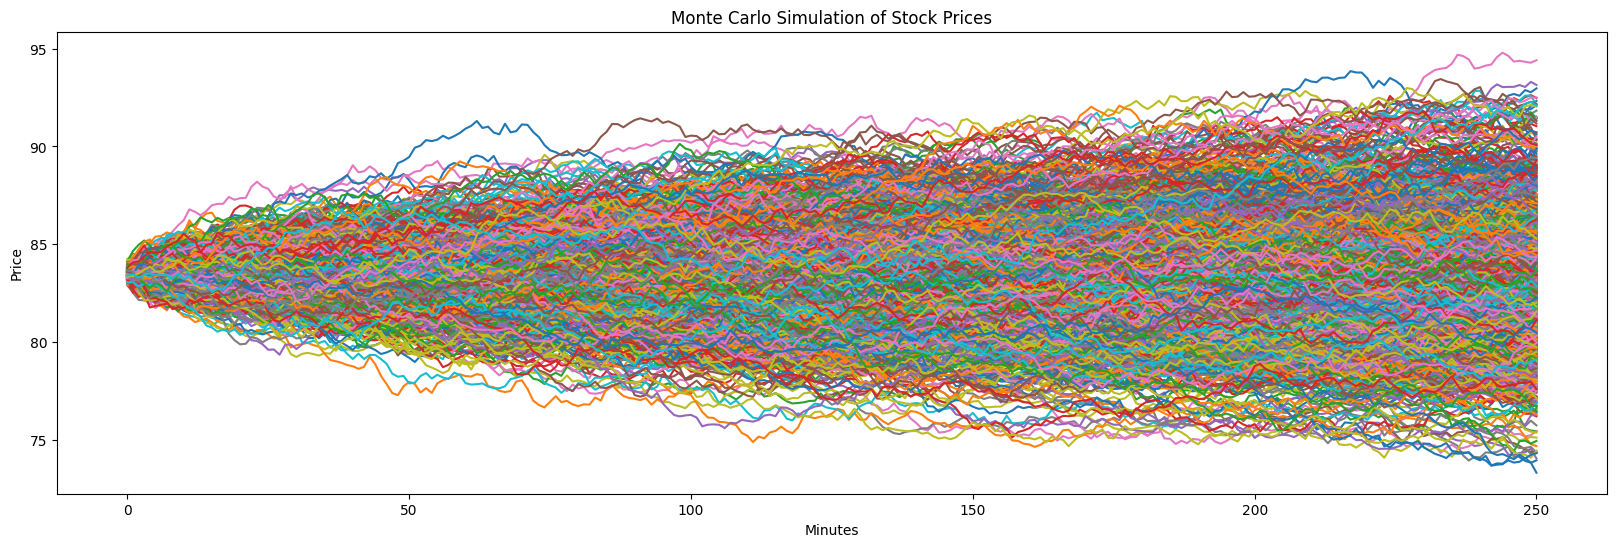

In [36]:
# Run the simulations
for x in range(num_simulations):
    count = 0
    daily_vol = data['Daily Return'].std()
    
    price_series = []
    price = last_price * (1 + np.random.normal(0, daily_vol))
    price_series.append(price)
    
    for y in range(num_minutes):
        price = price_series[count] * (1 + np.random.normal(0, daily_vol))
        price_series.append(price)
        count += 1
    
    simulation_df[x] = price_series

# Convert the last row of the simulation results into a list
sim = simulation_df.iloc[-1, :]

# Plot the simulations
plt.figure(figsize=(20, 6))
plt.plot(simulation_df)
plt.title('Monte Carlo Simulation of Stock Prices')
plt.xlabel('Minutes')
plt.ylabel('Price')
plt.show()

In [37]:
print(data['Close'].iloc[-num_minutes], data['Close'].iloc[-1]) 

83.5 82.8


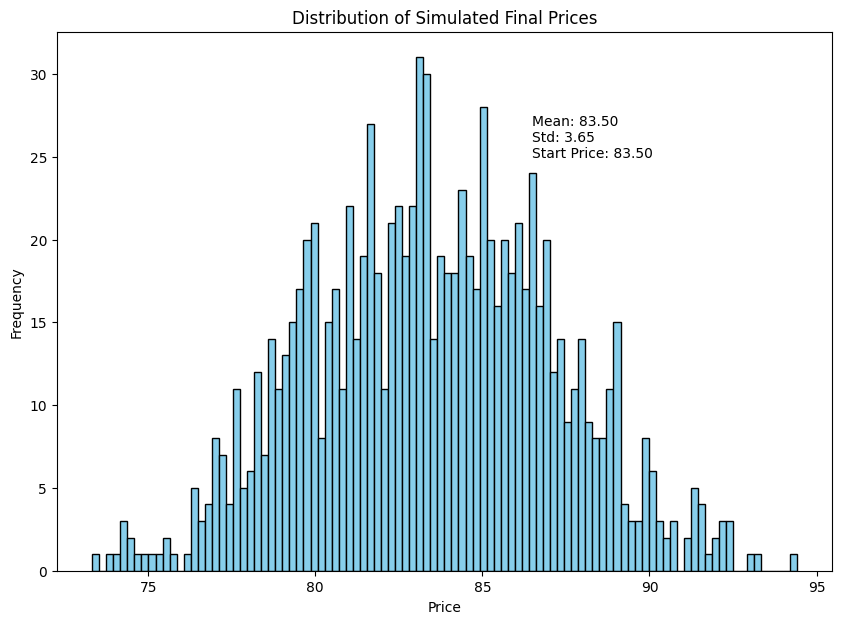

In [38]:
# Plot the histogram of the simulated final prices with color
plt.figure(figsize=(10, 7))
plt.hist(sim, bins=100, color='skyblue', edgecolor='black')
plt.figtext(0.6, 0.7, "Mean: {:.2f} \nStd: {:.2f} \nStart Price: {:.2f}".format(sim.mean(), sim.std(), last_price))
plt.title('Distribution of Simulated Final Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# 4. MONTE-CARLO SIMULATION WITH PRETRAINED LSTM

In [39]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [40]:
# Load your existing model
model = load_model('MSN.h5')

# Load and prepare your input data
# Replace this with your actual data loading and preparation code
data = pd.read_csv('MSN.csv')
data['Date/Time'] = pd.to_datetime(data['Date/Time'])
data = data.sort_values('Date/Time')
data.set_index('Date/Time', inplace=True)
close_prices = data['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

In [57]:
# Define parameters for simulation
num_simulations = 100  # Number of simulations
num_minutes = 300  # Number of days to simulate

# Prepare the input for prediction (using data from 100 minutes before the current time)
n_input = model.input_shape[1]
input_data = scaled_data[-(n_input + num_minutes):-num_minutes].reshape(1, n_input, 1)

# Run the Monte Carlo simulations
simulation_df = pd.DataFrame()

In [58]:
for sim in tqdm(range(num_simulations)):
    temp_input = input_data.copy()
    price_series = []

    for day in range(num_minutes):
        predicted_price = model.predict(temp_input, verbose=0)
        # Add some noise to the prediction
        predicted_price = predicted_price + np.random.normal(0, 0.01)  # Adjust noise level as needed
        
        # Inverse transform to get the real price
        real_predicted_price = scaler.inverse_transform(predicted_price)
        
        price_series.append(real_predicted_price[0, 0])
        
        # Update the input data for the next prediction
        new_input = np.append(temp_input[0, 1:], predicted_price)
        temp_input = new_input.reshape(1, n_input, 1)

    simulation_df[sim] = price_series

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [26:31<00:00, 15.91s/it]


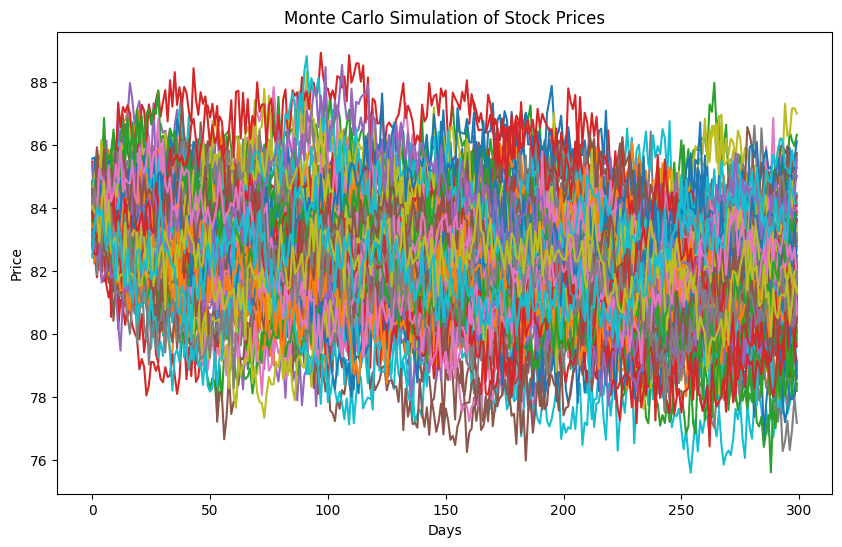

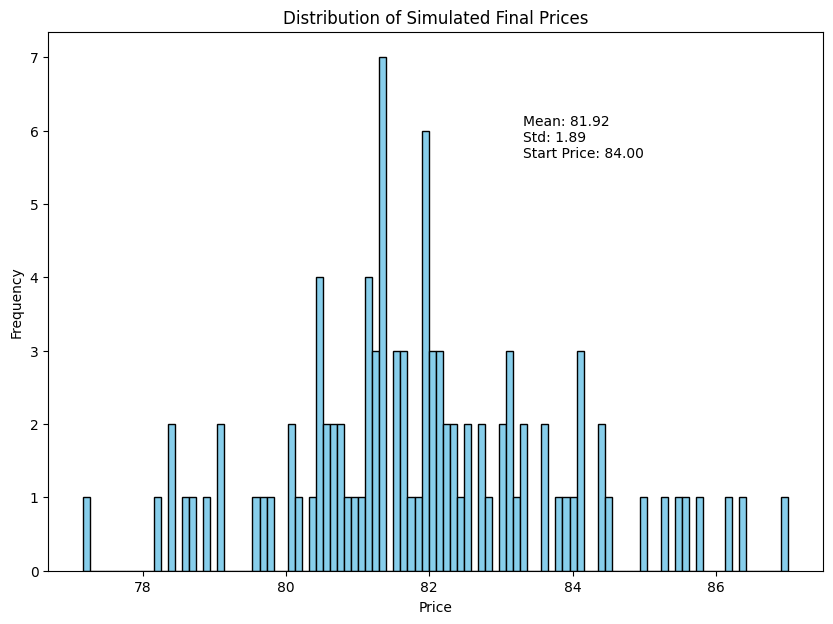

In [59]:
# Plot the simulations
plt.figure(figsize=(10, 6))
plt.plot(simulation_df)
plt.title('Monte Carlo Simulation of Stock Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

# Plot the histogram of the final prices
final_prices = simulation_df.iloc[-1, :]
plt.figure(figsize=(10, 7))
plt.hist(final_prices, bins=100, color='skyblue', edgecolor='black')
plt.figtext(0.6, 0.7, "Mean: {:.2f} \nStd: {:.2f} \nStart Price: {:.2f}".format(final_prices.mean(), final_prices.std(), close_prices[-num_minutes, 0]))
plt.title('Distribution of Simulated Final Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [60]:
print(close_prices[-num_minutes], close_prices[-1])

[84.] [82.8]


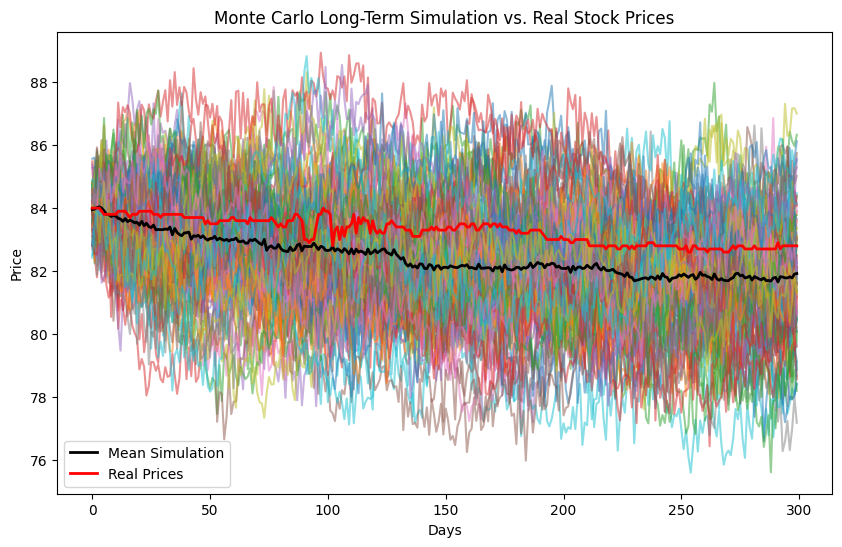

In [61]:
# Plot the simulations
plt.figure(figsize=(10, 6))
plt.plot(simulation_df, alpha=0.5)  # Plot all simulations with transparency for clarity
plt.plot(simulation_df.mean(axis=1), color='black', linestyle='-', linewidth=2, label='Mean Simulation')  # Plot mean line
plt.plot(close_prices[-num_minutes:], color='red', linestyle='-', linewidth=2, label='Real Prices')  # Plot real prices
plt.title('Monte Carlo Long-Term Simulation vs. Real Stock Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()